# 1. VHM Dataset

In [2]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [3]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price'].values.reshape(-1, 1)

In [4]:
df1

array([[68421.],
       [70075.],
       [68421.],
       ...,
       [39450.],
       [39000.],
       [38850.]])

In [5]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)

In [6]:
df1

array([[0.5961768 ],
       [0.62907782],
       [0.5961768 ],
       ...,
       [0.01989179],
       [0.01094048],
       [0.00795672]])

## Ratio 9:1

In [7]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [8]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [9]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [10]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [11]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
17/17 [==============================] - 1s 17ms/step - loss: 0.0724 - val_loss: 0.0022
Epoch 2/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0082 - val_loss: 0.0015
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 5/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 8/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 7.4677e-04
Epoch 9/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0012
Epoc

In [12]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [13]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [14]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1742.391608605704
Testing MAPE: 3.7210282953994507
Testing MAE: 1520.4180947580646


In [15]:
# !pip install "tensorflow==2.8.0"
# Chạy khi bị lỗi dòng dự báo

In [16]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


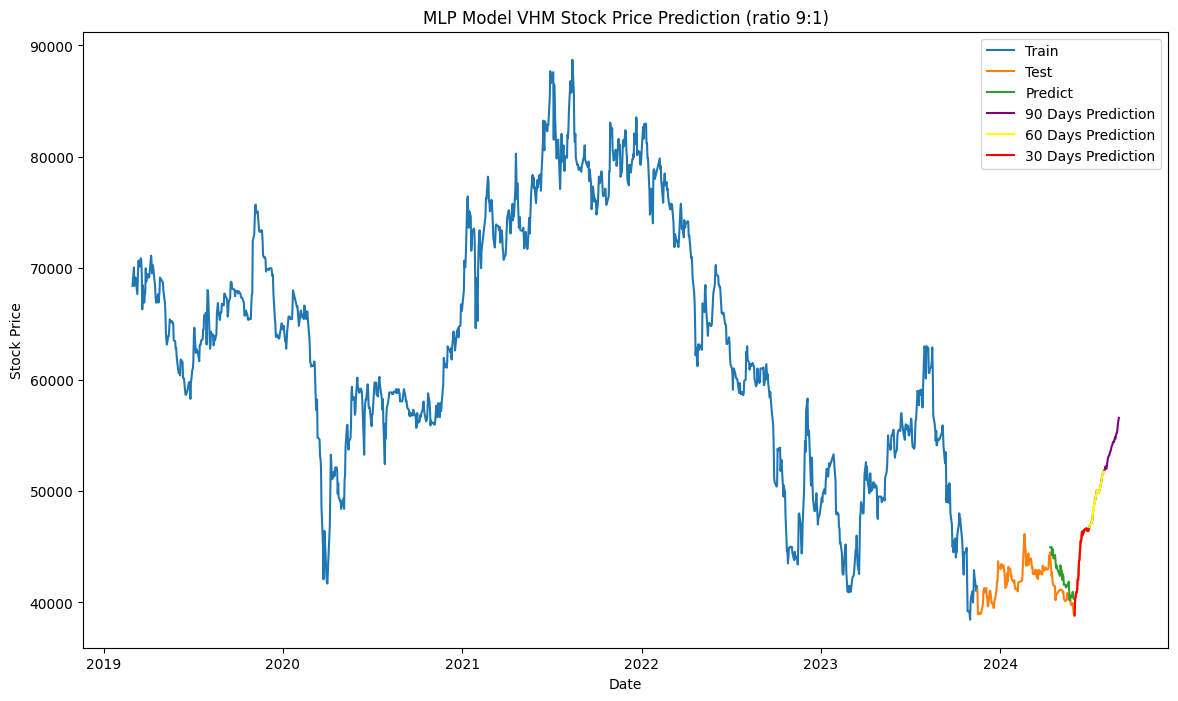

In [17]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model VHM Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 8:2

In [18]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [19]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [20]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [21]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [22]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
15/15 [==============================] - 1s 12ms/step - loss: 0.0676 - val_loss: 0.0151
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0100
Epoch 3/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0069 - val_loss: 0.0078
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0053
Epoch 10/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 11

In [23]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [24]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [25]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 2340.9583082300696
Testing MAPE: 4.336135960778169
Testing MAE: 1783.6032744984568


In [26]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


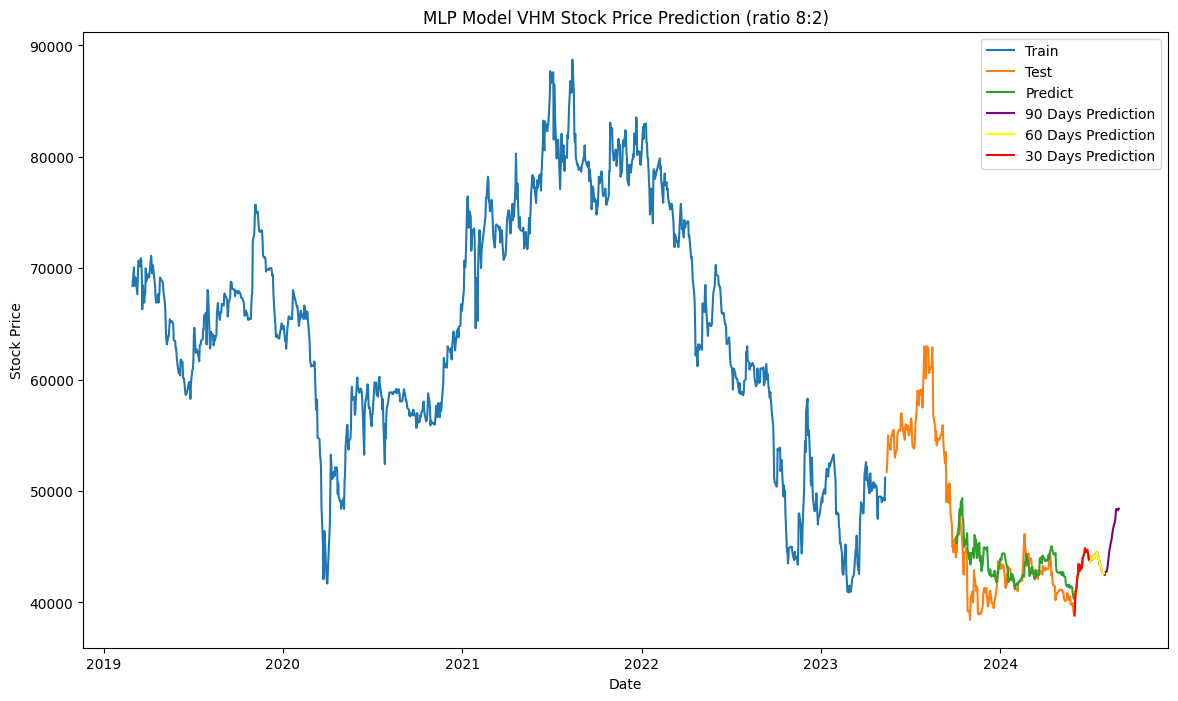

In [27]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model VHM Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 7:3

In [28]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [29]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [30]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [31]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [32]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
13/13 [==============================] - 1s 23ms/step - loss: 0.0991 - val_loss: 0.0108
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 0.0088
Epoch 3/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0097 - val_loss: 0.0071
Epoch 4/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 5/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0049 - val_loss: 0.0061
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.0053
Epoch 8/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 9/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0050
Epoch 10/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch

In [33]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [34]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [35]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 2761.180181931901
Testing MAPE: 5.004134883521455
Testing MAE: 2231.084510985495


In [36]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

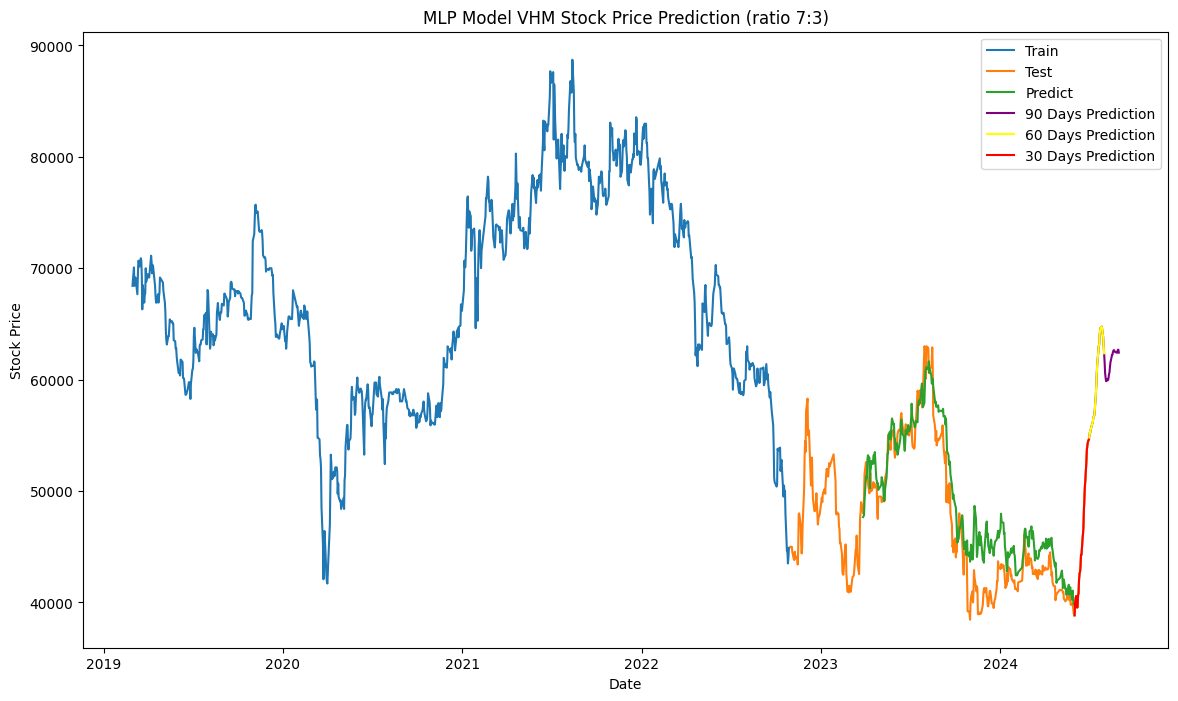

In [37]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model VHM Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

# 2. NVL Dataset

In [38]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [39]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price'].values.reshape(-1, 1)

In [40]:
df1

array([[32933.],
       [33100.],
       [32711.],
       ...,
       [14150.],
       [14150.],
       [14450.]])

In [41]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)

## Ratio 9:1

In [42]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [43]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [44]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [45]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [46]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
17/17 [==============================] - 1s 17ms/step - loss: 0.0810 - val_loss: 0.0025
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 4.2542e-04
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 5.7834e-04
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 5.0742e-04
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 2.1410e-04
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 1.9689e-04
Epoch 8/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 2.4240e-04
Epoch 9/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 3.1613e-04
Epoch 10/100
17/17 [==============================] - 0s 4ms/step - loss: 9.4997

In [47]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [48]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [49]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 859.9274863619029
Testing MAPE: 4.053077387262879
Testing MAE: 597.8922316028226


In [50]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


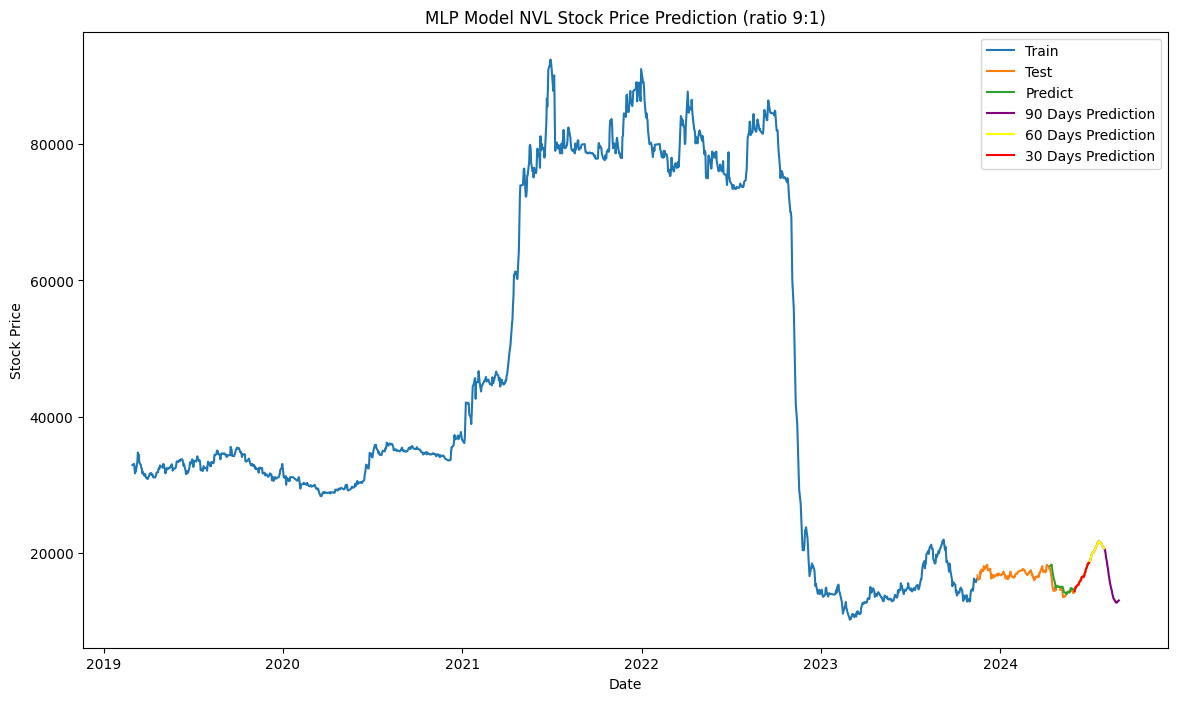

In [51]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model NVL Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 8:2

In [52]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [53]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [54]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [55]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [56]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
15/15 [==============================] - 1s 19ms/step - loss: 0.0450 - val_loss: 0.0010
Epoch 2/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0062 - val_loss: 3.1080e-04
Epoch 3/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 4.0540e-04
Epoch 4/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 2.7646e-04
Epoch 5/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 2.3555e-04
Epoch 6/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 2.1119e-04
Epoch 7/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 1.9466e-04
Epoch 8/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 1.9256e-04
Epoch 9/100
15/15 [==============================] - 0s 7ms/step - loss: 9.7292e-04 - val_loss: 1.7605e-04
Epoch 10/100
15/15 [==============================] - 0s 8ms/step - lo

In [57]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [58]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [59]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1020.4288896096646
Testing MAPE: 5.44810209686111
Testing MAE: 863.2558533468364


In [60]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

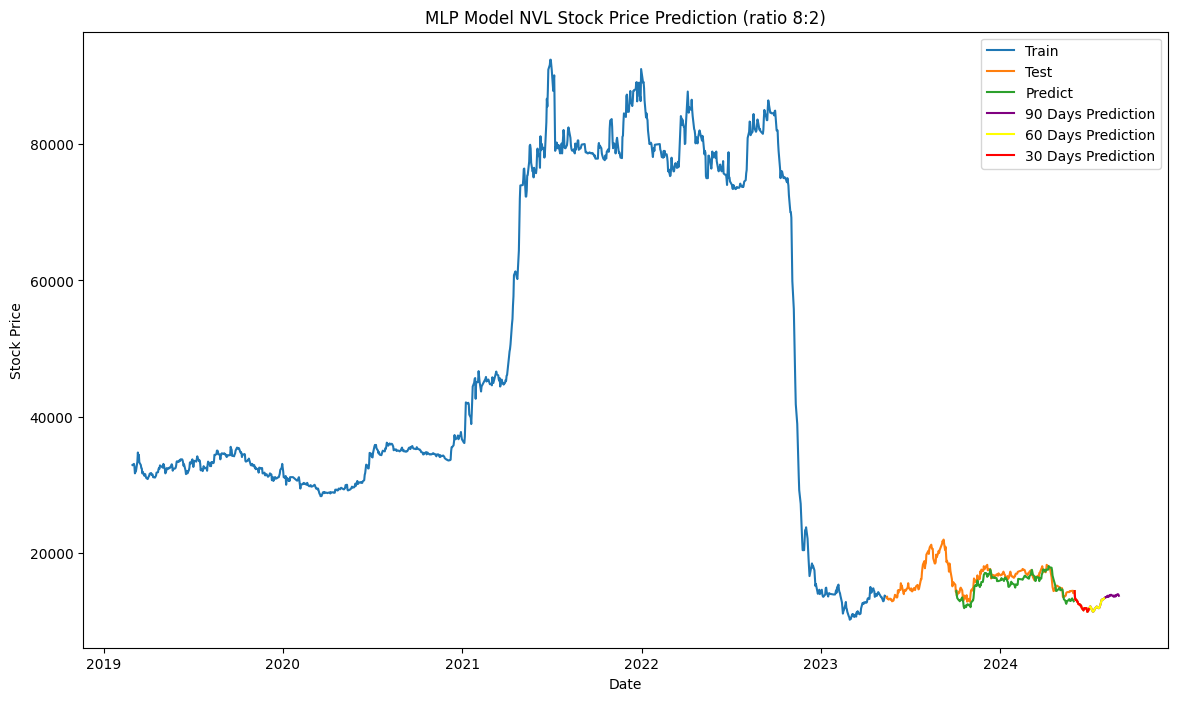

In [61]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model NVL Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 7:3

In [62]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [63]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [64]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [65]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [66]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
13/13 [==============================] - 1s 23ms/step - loss: 0.0305 - val_loss: 8.8294e-04
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0062 - val_loss: 0.0013
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 4/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 9.9230e-04
Epoch 8/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 9.9610e-04
Epoch 9/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 7.9738e-04
Epoch 10/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss

In [67]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [68]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [69]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 2018.3692717829701
Testing MAPE: 9.369843556897042
Testing MAE: 1415.8889485121588


In [70]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

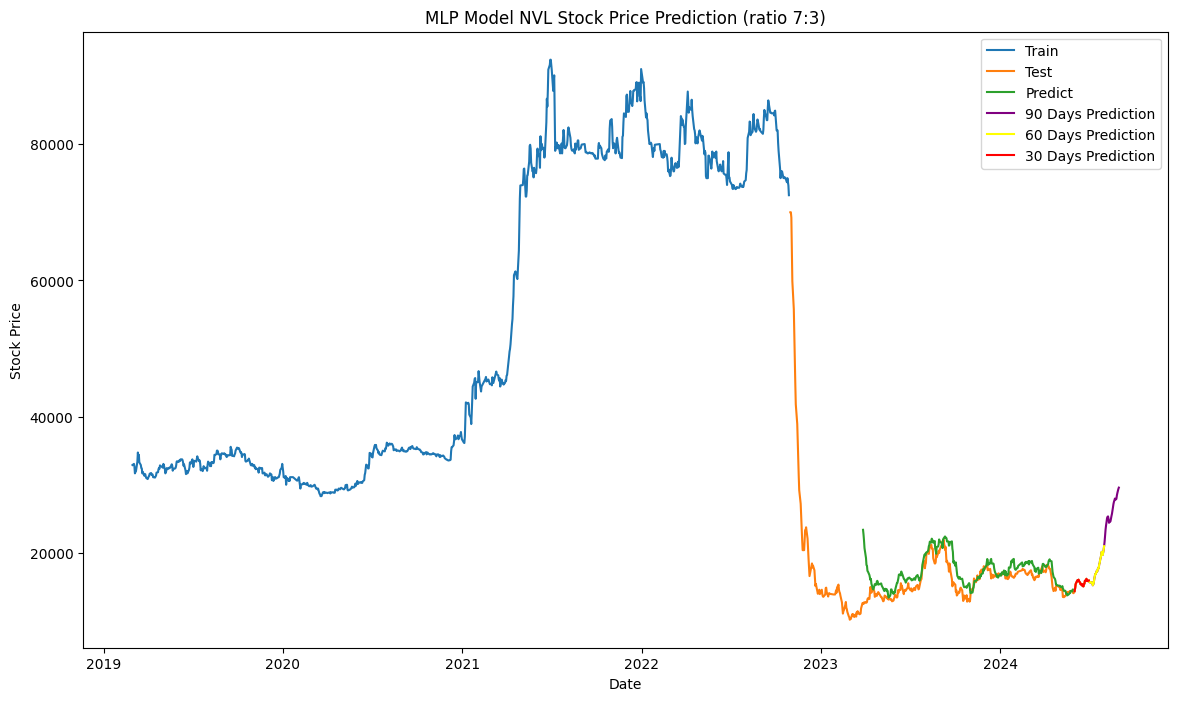

In [71]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model NVL Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

# 3. NLG Dataset

In [72]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [73]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price'].values.reshape(-1, 1)

In [74]:
df1

array([[18706.8],
       [19127.2],
       [18917. ],
       ...,
       [44400. ],
       [43700. ],
       [44000. ]])

In [75]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)

## Ratio 9:1

In [76]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [77]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [78]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [79]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [80]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
17/17 [==============================] - 1s 14ms/step - loss: 0.0170 - val_loss: 0.0056
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0052
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 8/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 9/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 10/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 11

In [81]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [82]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [83]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1804.90858164525
Testing MAPE: 3.507803368850746
Testing MAE: 1409.2806199596773


In [84]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

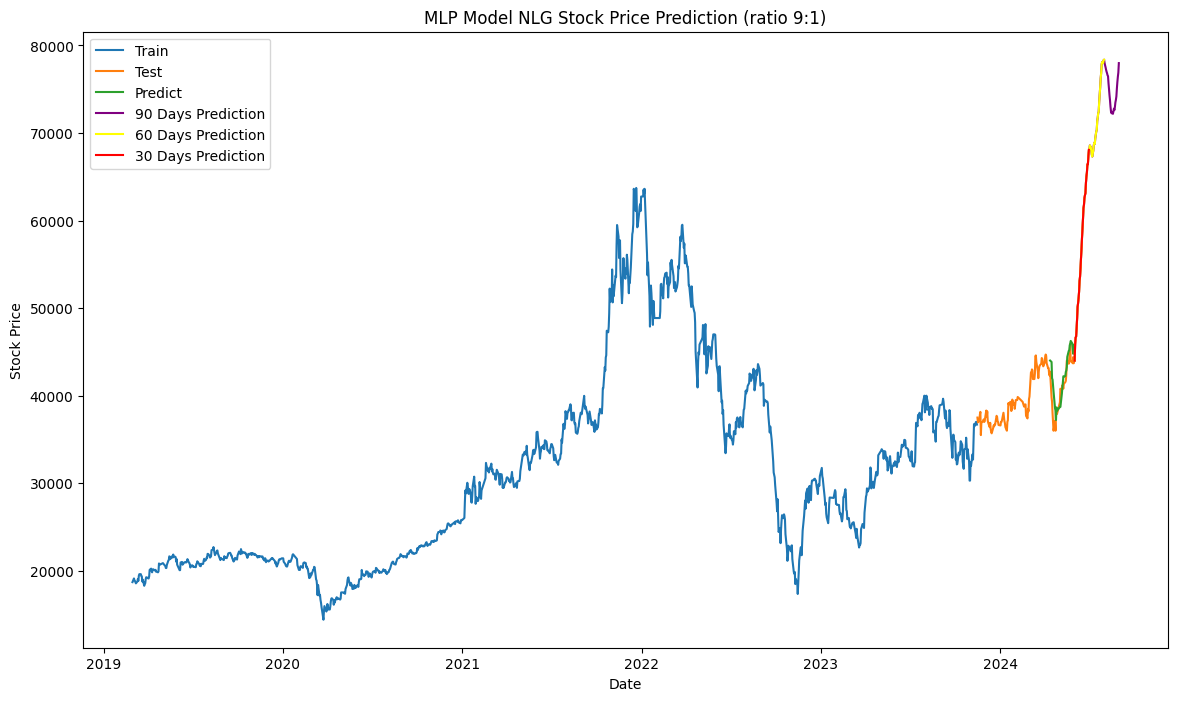

In [85]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model NLG Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Ratio 8:2

In [86]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [87]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [88]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [89]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [90]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
15/15 [==============================] - 1s 13ms/step - loss: 0.0121 - val_loss: 0.0039
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 9.5576e-04 - val_loss: 0.0014
Epoch 9/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoc

In [91]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [92]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [93]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1315.1114188047593
Testing MAPE: 2.7048598088055833
Testing MAE: 1026.3070505401236


In [94]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

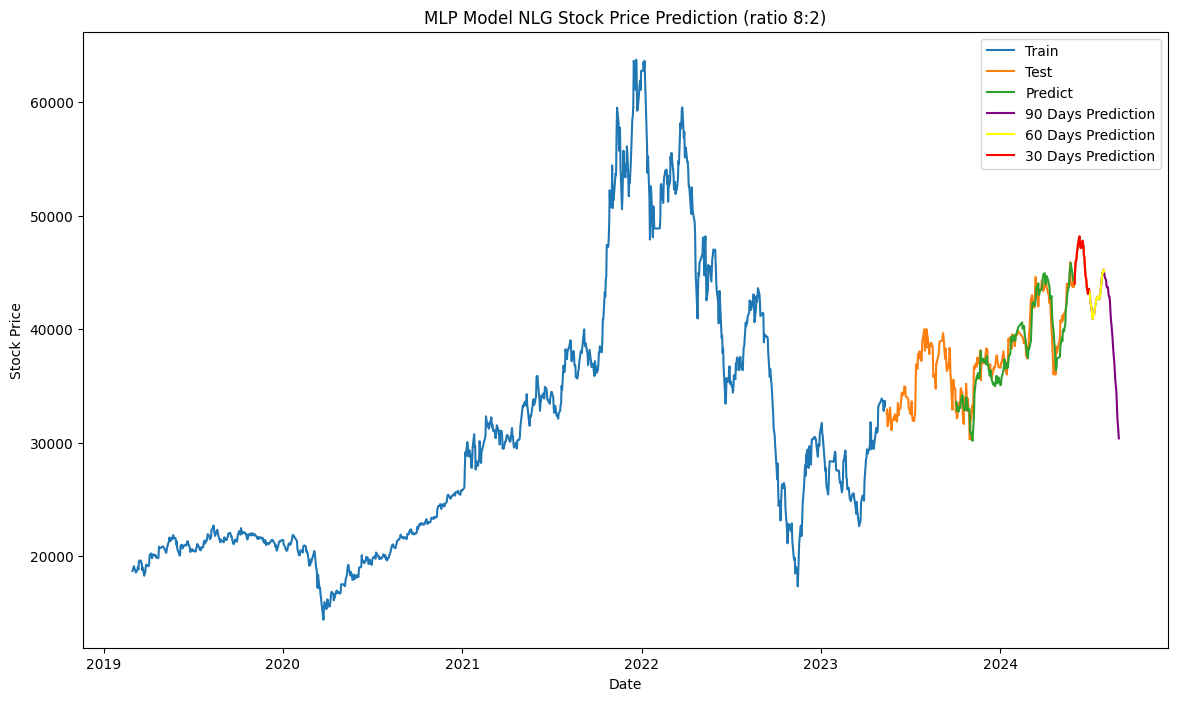

In [95]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model NLG Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Ratio 7:3

In [96]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [97]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [98]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [99]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [100]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
13/13 [==============================] - 1s 26ms/step - loss: 0.0739 - val_loss: 0.0156
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0087 - val_loss: 0.0025
Epoch 3/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 5/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 7/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 8/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 9/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 

In [101]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [102]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [103]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1496.061951113269
Testing MAPE: 3.3152263579099506
Testing MAE: 1188.0025263971843


In [104]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

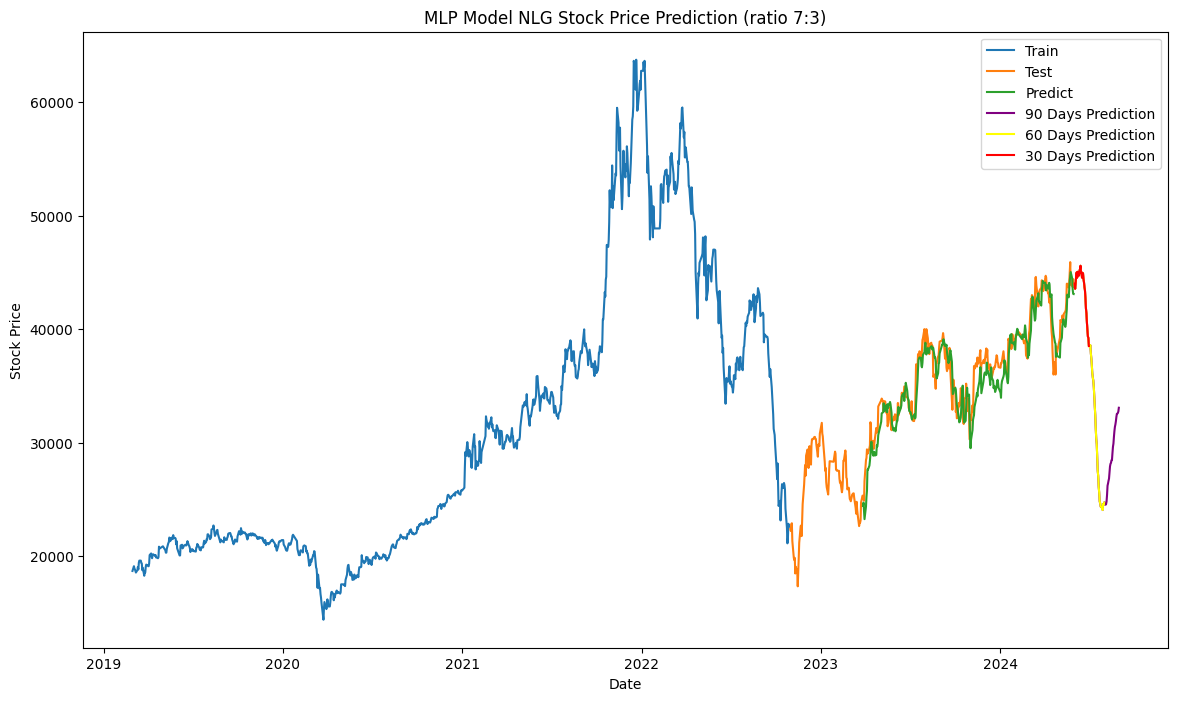

In [105]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model NLG Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()
